# Developer Insights and Compensation Analysis

This notebook aims to analyze developer trends and predict developer compensation using survey data. The process follows the CRISP-DM framework, including data exploration, cleaning, modeling, and visualization.

## Goals:

1. Identify trends in developer tools and technologies.
2. Predict developer compensation based on key features.
3. Provide actionable insights for stakeholders in the technology sector.


In [1]:
# import libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
import random

## Step 1: Data Loading

The dataset is loaded to begin exploration.


In [2]:
# Read the data
raw_data = pd.read_csv(r'data\survey_results_public.csv')

In [3]:
# Load the data
data = raw_data[['ResponseId', 'MainBranch', 'Age', 'Employment', 'EdLevel', 'YearsCode',
                 'DevType', 'Country', 'Currency', 'CompTotal', 'LanguageHaveWorkedWith', 'Industry']]

## Step 2: Exploratory Data Analysis (EDA)

In this section, we analyze the dataset to uncover trends, distributions, and potential data quality issues. The focus includes:

1. **Most Popular Programming Languages**: Identify the most frequently used programming languages across all developers and by industry.
2. **Developer Roles Distribution**: Examine the distribution of developer roles across different demographics.
3. **Compensation Trends**: Explore the distribution of compensation and its relationship with other factors, such as developer type and years of experience.


In [4]:
# Overview of dataset dimensions and missing values
print(f"Dataset contains {data.shape[0]} rows and {data.shape[1]} columns.\n")

# Check for missing values and visualize them
missing_values = data.isnull().sum()
print("Missing Values in Each Column:\n", missing_values)

Dataset contains 65437 rows and 12 columns.

Missing Values in Each Column:
 ResponseId                    0
MainBranch                    0
Age                           0
Employment                    0
EdLevel                    4653
YearsCode                  5568
DevType                    5992
Country                    6507
Currency                  18753
CompTotal                 31697
LanguageHaveWorkedWith     5692
Industry                  36579
dtype: int64


In [5]:
# Check how many unique values are in each column
print(data.nunique())

ResponseId                65437
MainBranch                    5
Age                           8
Employment                  110
EdLevel                       8
YearsCode                    52
DevType                      34
Country                     185
Currency                    142
CompTotal                  3337
LanguageHaveWorkedWith    23864
Industry                     15
dtype: int64


In [6]:
# Drop rows with missing values in the 'CompTotal' column
data = data.dropna(subset=['CompTotal'])

In [7]:
# Data info after dropping missing values
print(f"Data shape after dropping missing values: {data.shape}")
print(data.isnull().sum())

Data shape after dropping missing values: (33740, 12)
ResponseId                    0
MainBranch                    0
Age                           0
Employment                    0
EdLevel                       0
YearsCode                    59
DevType                      37
Country                       0
Currency                      0
CompTotal                     0
LanguageHaveWorkedWith      312
Industry                  11520
dtype: int64


In [8]:
# check the data types of the columns
print(data.dtypes)

ResponseId                  int64
MainBranch                 object
Age                        object
Employment                 object
EdLevel                    object
YearsCode                  object
DevType                    object
Country                    object
Currency                   object
CompTotal                 float64
LanguageHaveWorkedWith     object
Industry                   object
dtype: object


In [9]:
# Convert 'YearsCode' column to numeric
data['YearsCode'] = data['YearsCode'].apply(
    lambda x: 50 if x == 'More than 50 years' else x)
data['YearsCode'] = data['YearsCode'].apply(
    lambda x: 0 if x == 'Less than 1 year' else x)

In [10]:
# convert the YearsCode column to numeric
data['YearsCode'] = pd.to_numeric(
    data['YearsCode'], errors='coerce').astype('Int64')

In [11]:
# Describe the data
print(data.describe(include='all'))

          ResponseId                      MainBranch              Age  \
count   33740.000000                           33740            33740   
unique           NaN                               2                8   
top              NaN  I am a developer by profession  25-34 years old   
freq             NaN                           31004            14657   
mean    29642.268998                             NaN              NaN   
std     17511.008037                             NaN              NaN   
min        73.000000                             NaN              NaN   
25%     14729.750000                             NaN              NaN   
50%     28744.000000                             NaN              NaN   
75%     44318.500000                             NaN              NaN   
max     65432.000000                             NaN              NaN   

                 Employment                                       EdLevel  \
count                 33740                   

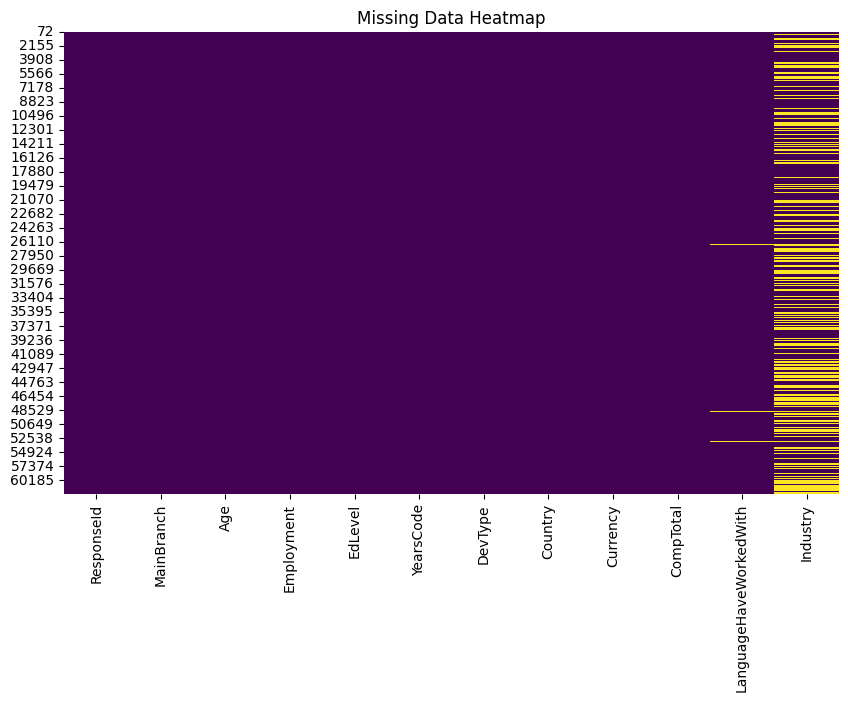

In [12]:
# Visualize missing values
plt.figure(figsize=(10, 6))
sns.heatmap(data.isnull(), cbar=False, cmap="viridis")
plt.title("Missing Data Heatmap")
plt.show()

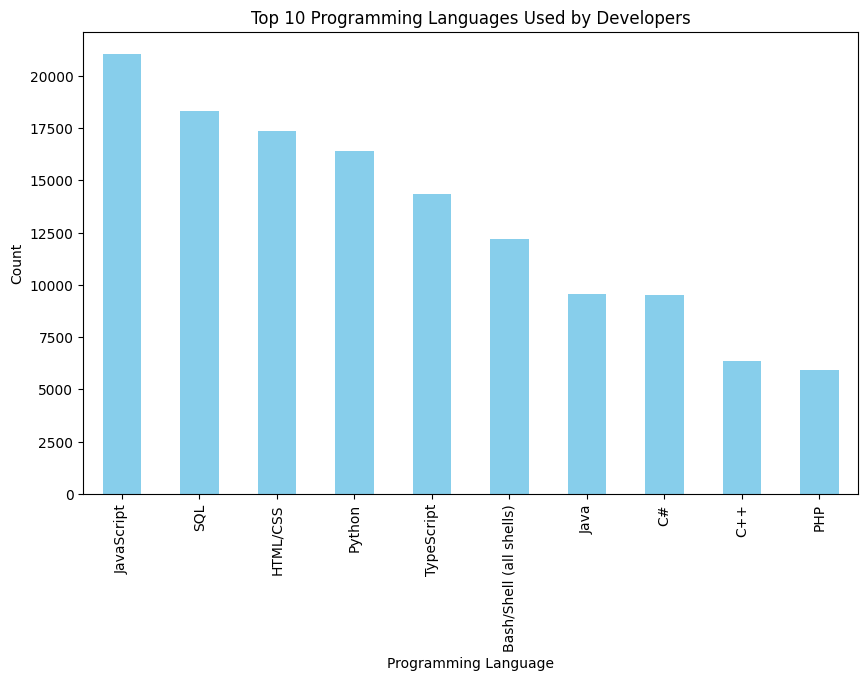

In [13]:
# Visualize the most popular programming languages
language_counts = data['LanguageHaveWorkedWith'].str.split(
    ';').explode().value_counts().head(10)

plt.figure(figsize=(10, 6))
language_counts.plot(kind='bar', color='skyblue')
plt.title("Top 10 Programming Languages Used by Developers")
plt.xlabel("Programming Language")
plt.ylabel("Count")
plt.show()

## Answering the question:

### What are the most common programming languages used by developers in different industries?


In [14]:
# Split the 'LanguageHaveWorkedWith' column into individual languages
data_LanguageHaveWorkedWith = data.assign(
    LanguageHaveWorkedWith=data['LanguageHaveWorkedWith'].str.split(';'))

# Explode the lists in 'LanguageHaveWorkedWith' into individual rows
data_LanguageHaveWorkedWith = data_LanguageHaveWorkedWith.explode(
    'LanguageHaveWorkedWith')

# Now group by Industry and LanguageHaveWorkedWith
industry_language = data_LanguageHaveWorkedWith.groupby(
    'Industry')['LanguageHaveWorkedWith'].value_counts().unstack()

# Fill NaN values with 0 to avoid issues during division
industry_language = industry_language.fillna(0)

# Turn counts into percentages
industry_language = industry_language.div(
    industry_language.sum(axis=1), axis=0)

# Transpose the data
industry_language = industry_language.transpose()

In [15]:
# To answer the question we get the most common languages for each industry by sorting the values to get the top and plotting it

# Get the most common languages for each industry
most_common_languages = {}

for col in industry_language.columns:
    most_language = industry_language[col].idxmax()
    percentage = (industry_language[col].max() * 100).round(2)
    most_common_languages[col] = {
        'language': most_language, 'percentage': percentage}

    print(f"{col}: {most_language}, At: {
          percentage}% of developers in the industry\n")

Banking/Financial Services: JavaScript, At: 11.57% of developers in the industry

Computer Systems Design and Services: Python, At: 10.77% of developers in the industry

Energy: Python, At: 11.18% of developers in the industry

Fintech: JavaScript, At: 11.92% of developers in the industry

Government: JavaScript, At: 11.83% of developers in the industry

Healthcare: JavaScript, At: 11.79% of developers in the industry

Higher Education: Python, At: 11.55% of developers in the industry

Insurance: JavaScript, At: 12.93% of developers in the industry

Internet, Telecomm or Information Services: JavaScript, At: 11.34% of developers in the industry

Manufacturing: JavaScript, At: 10.32% of developers in the industry

Media & Advertising Services: JavaScript, At: 12.52% of developers in the industry

Other:: JavaScript, At: 11.11% of developers in the industry

Retail and Consumer Services: JavaScript, At: 12.48% of developers in the industry

Software Development: JavaScript, At: 12.31% of

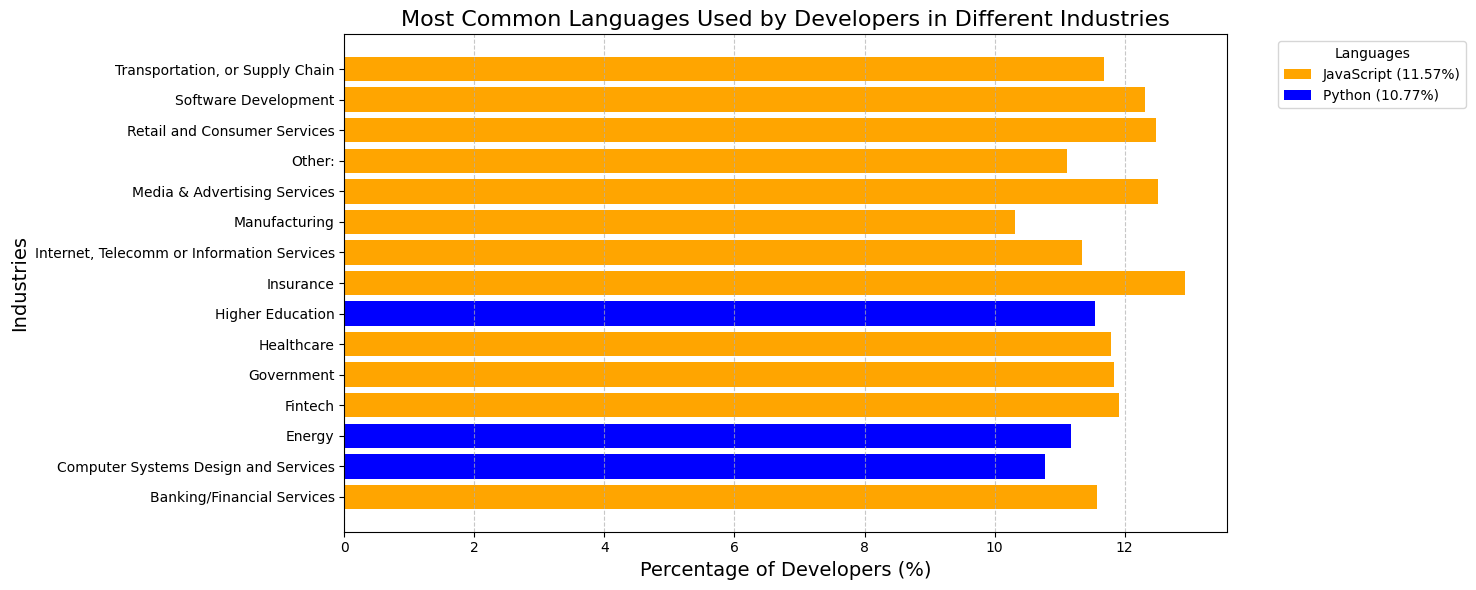

In [16]:
# Create a horizontal bar plot to highlight the most common languages
# Define specific colors for Python and JavaScript
language_colors = {
    "Python": "blue",
    "JavaScript": "orange"
}

# Create a horizontal bar plot
# Track languages already added to the legend
added_to_legend = set()

# Create a horizontal bar plot
plt.figure(figsize=(15, 6))

for idx, (industry, most_common_languages_viz_data) in enumerate(most_common_languages.items()):
    # Choose color based on the language
    language = most_common_languages_viz_data['language']
    color = language_colors.get(language)

    # Add label only if the language is not already in the legend
    label = f"{language} ({
        most_common_languages_viz_data['percentage']}%)" if language not in added_to_legend else None
    if label:
        added_to_legend.add(language)

    plt.barh(
        industry, most_common_languages_viz_data['percentage'], color=color, label=label)

plt.title(
    'Most Common Languages Used by Developers in Different Industries', fontsize=16)
plt.xlabel('Percentage of Developers (%)', fontsize=14)
plt.ylabel('Industries', fontsize=14)
plt.legend(title='Languages', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Answering the question:

### How Does Developer Type Impact Total Compensation?

This analysis examines how developer type influences total compensation.
Steps:

1. Convert all currencies to a common base (USD) using exchange rates.
2. Filter extreme outliers (top and bottom 1%) to avoid skewing results.
3. Analyze and visualize average and median compensation by developer type.


In [17]:
# Keep only the rows with the top 3 most common currencies
currencies_to_keep = ['EUR European Euro',
                      'USD\tUnited States dollar', 'GBP\tPound sterling']
data = data[data['Currency'].isin(currencies_to_keep)]

In [18]:
# Convert currencies to a common currency (USD)
# Define the conversion rates
conversion_rates = {
    'EUR European Euro': 1.04,
    'USD\tUnited States dollar': 1,
    'GBP\tPound sterling': 1.23
}

# Convert the compensation to USD
data['CompTotal'] = data.apply(
    lambda x: x['CompTotal'] / conversion_rates[x['Currency']], axis=1
)

# Rename the 'CompTotal' column to 'CompTotalUSD'
data = data.rename(columns={'CompTotal': 'CompTotalUSD'})

In [19]:
# Handle outliers (capping extreme values at the 99th percentile)
upper_limit = data['CompTotalUSD'].quantile(0.95)
lower_limit = data['CompTotalUSD'].quantile(0.05)

data_cleaned = data[data['CompTotalUSD'] <= upper_limit]
data_cleaned = data_cleaned[data_cleaned['CompTotalUSD'] >= lower_limit]

print(f"Removed outliers. Dataset now contains {
      data_cleaned.shape[0]} rows.\n")
print(f"Compensation Range After Filtering: ${
      lower_limit:.2f} - ${upper_limit:.2f}")

# Calculate mean and median compensation by developer type
position_compensation = data_cleaned.groupby('DevType')['CompTotalUSD'].agg(
    mean_compensation='mean', median_compensation='median'
).sort_values('mean_compensation', ascending=False)

# Display results
print("Average Compensation by Developer Type (Top 10):\n")
print(position_compensation.head(10))

Removed outliers. Dataset now contains 18306 rows.

Compensation Range After Filtering: $15600.00 - $240384.62
Average Compensation by Developer Type (Top 10):

                                      mean_compensation  median_compensation
DevType                                                                     
Engineer, site reliability                121293.370267        105384.615385
Engineering manager                       120952.900110        107317.073171
Developer Advocate                        115019.702460        101000.000000
Senior Executive (C-Suite, VP, etc.)      114715.243970        101219.512195
Developer Experience                      114530.411875        112500.000000
Marketing or sales professional           107494.505495         99807.692308
Blockchain                                106057.047808         97560.975610
Security professional                     105551.055347         89430.894309
Cloud infrastructure engineer             105011.795309         91346

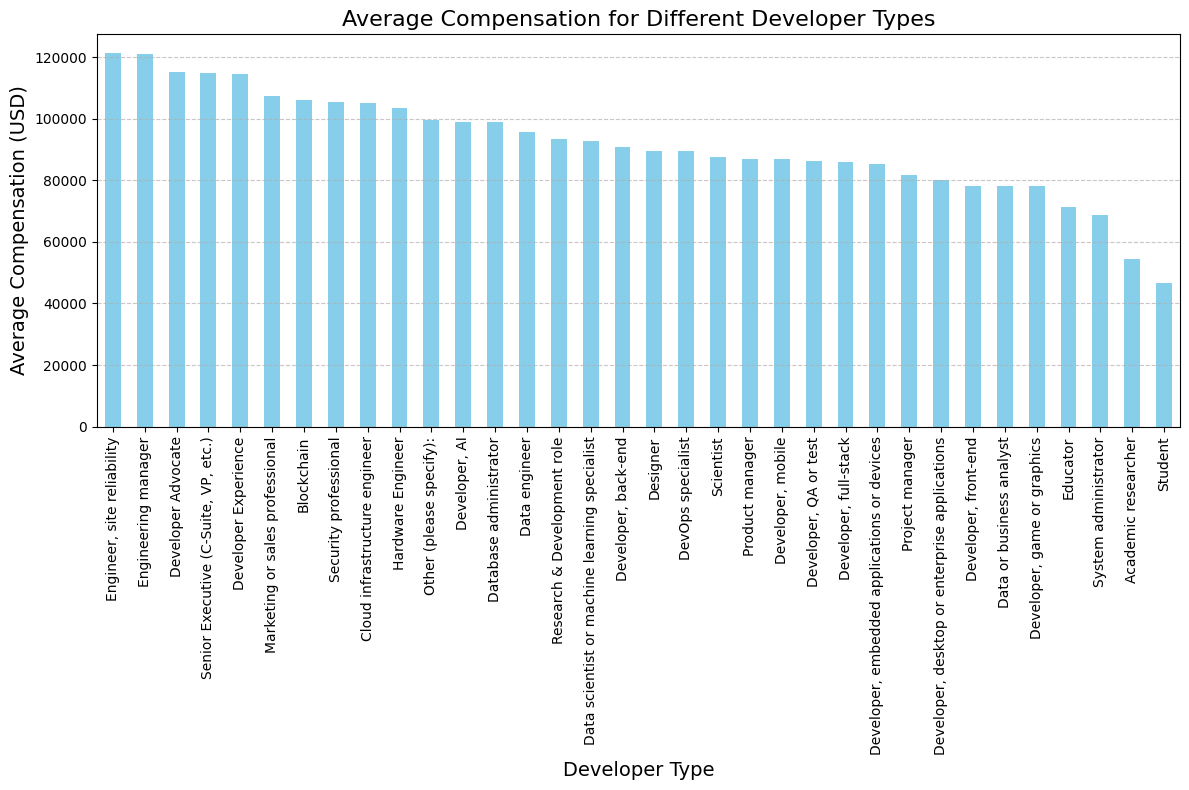

In [20]:
# Plot the average compensation for different developer types
plt.figure(figsize=(12, 8))
position_compensation['mean_compensation'].plot(kind='bar', color='skyblue')
plt.title('Average Compensation for Different Developer Types', fontsize=16)
plt.xlabel('Developer Type', fontsize=14)
plt.ylabel('Average Compensation (USD)', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Answering the question:

### What is the preferred programming language for developers based on the developer type?


In [21]:
# Split the 'LanguageHaveWorkedWith' column into individual languages
data_LanguageHaveWorkedWith = data.assign(
    LanguageHaveWorkedWith=data['LanguageHaveWorkedWith'].str.split(';'))

# Explode the lists in 'LanguageHaveWorkedWith' into individual rows
data_LanguageHaveWorkedWith = data_LanguageHaveWorkedWith.explode(
    'LanguageHaveWorkedWith')

# Group by Developer Type and Language
devtype_language = data_LanguageHaveWorkedWith.groupby(
    'DevType')['LanguageHaveWorkedWith'].value_counts().unstack()

# Fill NaN values with 0 to avoid issues during division
devtype_language = devtype_language.fillna(0)

# Convert counts into percentages
devtype_language = devtype_language.div(
    devtype_language.sum(axis=1), axis=0)

# Transpose the data for easier analysis
devtype_language = devtype_language.transpose()

In [22]:
# To answer the question we get the most used languages for each DevType by sorting the values to get the top and ploting it
# Get the most used languages for each Developer Type
most_used_languages = {}

for col in devtype_language.columns:
    most_used_language = devtype_language[col].idxmax()
    percentage = (devtype_language[col].max() * 100).round(2)
    most_used_languages[col] = {
        'language': most_used_language,
        'percentage': percentage
    }

    print(f"{col}: {most_used_language}, At: {
          percentage}% of developers in the role\n")

Academic researcher: Python, At: 16.21% of developers in the role

Blockchain: JavaScript, At: 10.49% of developers in the role

Cloud infrastructure engineer: Python, At: 12.63% of developers in the role

Data engineer: Python, At: 18.98% of developers in the role

Data or business analyst: SQL, At: 18.12% of developers in the role

Data scientist or machine learning specialist: Python, At: 21.65% of developers in the role

Database administrator: SQL, At: 17.87% of developers in the role

Designer: JavaScript, At: 14.35% of developers in the role

DevOps specialist: Python, At: 12.38% of developers in the role

Developer Advocate: JavaScript, At: 8.86% of developers in the role

Developer Experience: JavaScript, At: 10.68% of developers in the role

Developer, AI: Python, At: 17.29% of developers in the role

Developer, QA or test: Python, At: 12.85% of developers in the role

Developer, back-end: SQL, At: 11.93% of developers in the role

Developer, desktop or enterprise application

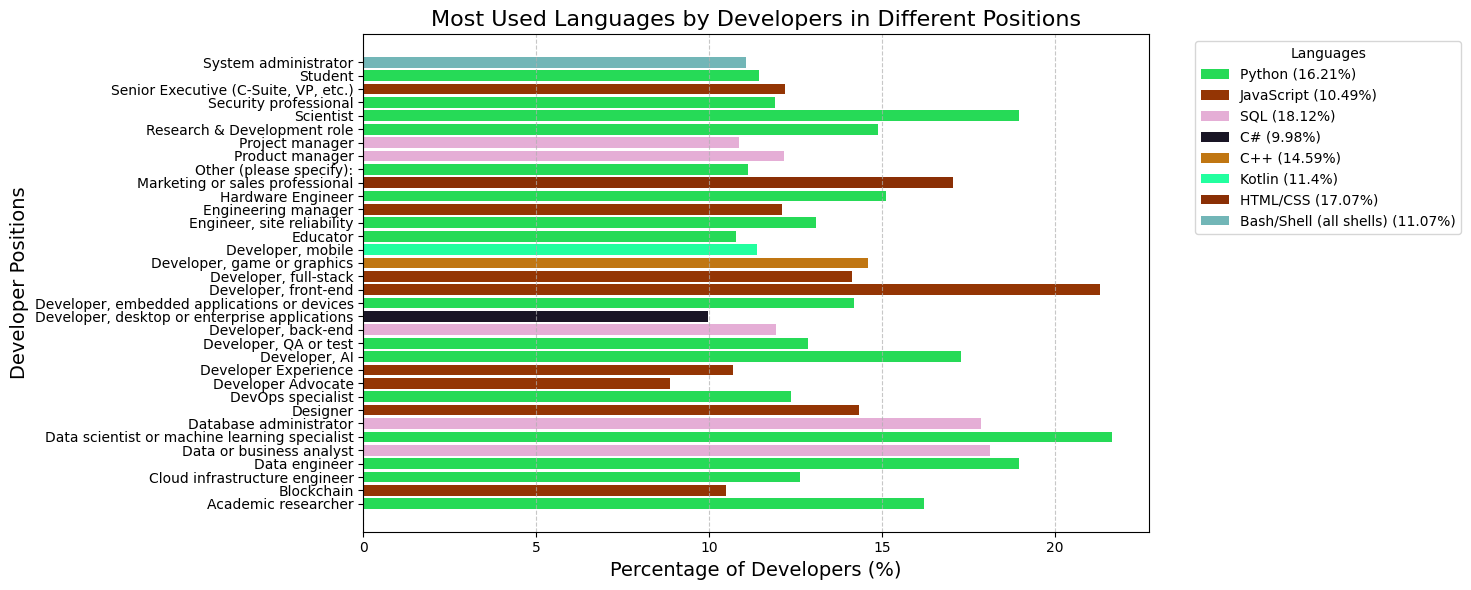

In [32]:
# Create a horizontal bar plot to highlight the most used languages
# Function to generate random colors
def get_random_color():
    return "#{:06x}".format(random.randint(0, 0xFFFFFF))


# Track already added languages and assign random colors
added_to_legend = set()
language_colors = {}

# Create a horizontal bar plot to highlight the most used languages
plt.figure(figsize=(15, 6))

for idx, (devtype, most_used_languages_viz_data) in enumerate(most_used_languages.items()):
    # Choose or assign a random color for the language
    language = most_used_languages_viz_data['language']
    if language not in language_colors:
        language_colors[language] = get_random_color()
    color = language_colors[language]

    # Add label only if the language is not already in the legend
    if language not in added_to_legend:
        label = f"{language} ({most_used_languages_viz_data['percentage']}%)"
        added_to_legend.add(language)
    else:
        label = None

    # Create the horizontal bar
    plt.barh(
        devtype, most_used_languages_viz_data['percentage'], color=color, label=label
    )

# Add title and labels
plt.title('Most Used Languages by Developers in Different Positions', fontsize=16)
plt.xlabel('Percentage of Developers (%)', fontsize=14)
plt.ylabel('Developer Positions', fontsize=14)

# Add legend
plt.legend(title='Languages', bbox_to_anchor=(1.05, 1), loc='upper left')

# Add grid for clarity
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

## Create a Machine Learning Model to Predict Salary

### Step 1: Prepare the Data for Modeling

We will process the data to make it suitable for training a machine learning model:

- Convert `LanguageHaveWorkedWith` into one-hot encoded features.
- Drop irrelevant or non-numeric columns.
- Handle missing values and filter outliers.
- Split the dataset into training and testing sets.


In [24]:
# Step 1: One-Hot Encoding for Programming Languages
data = data.assign(
    LanguageHaveWorkedWith=data['LanguageHaveWorkedWith'].str.split(';'))
data = data.explode('LanguageHaveWorkedWith')
data = pd.get_dummies(data, columns=['LanguageHaveWorkedWith'], prefix='Lang')

In [25]:
# Step 2: Drop unnecessary columns
columns_to_drop = ['ResponseId', 'EdLevel',
                   'Employment', 'MainBranch', 'Currency', 'Country']
data_cleaned = data.drop(columns=columns_to_drop).dropna()

In [26]:
# Step 3: One-Hot Encoding for Categorical Variables
categorical_columns = ['Age', 'DevType', 'Industry']
data_cleaned = pd.get_dummies(
    data_cleaned, columns=categorical_columns, drop_first=True)

In [27]:
# Step 4: Filter Outliers in Compensation
upper_limit = data_cleaned['CompTotalUSD'].quantile(0.85)
lower_limit = data_cleaned['CompTotalUSD'].quantile(0.15)
data_cleaned = data_cleaned[
    (data_cleaned['CompTotalUSD'] <= upper_limit) & (
        data_cleaned['CompTotalUSD'] >= lower_limit)
]

In [28]:
# Step 5: Define Features and Target Variable
X = data_cleaned.drop(columns=['CompTotalUSD'])
y = data_cleaned['CompTotalUSD']

In [29]:
# Step 6: Split Data into Training and Test Sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=84)

In [30]:
# Train a Linear Regression Model
model = LinearRegression()
model.fit(X_train, y_train)

# Make Predictions
y_pred = model.predict(X_test)

# Evaluate the Model
# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = model.score(X_test, y_test)
adjusted_r2 = 1 - (1-r2) * (len(y) - 1) / (len(y) - X.shape[1] - 1)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared: {r2}")
print(f"Adjusted R-squared: {adjusted_r2}")
# Display Model Coefficients
coefficients = pd.DataFrame(model.coef_, X.columns, columns=['Coefficient'])
coefficients = coefficients.sort_values('Coefficient', ascending=False)
print("Feature Importance:\n", coefficients)

Mean Squared Error (MSE): 1135047637.4862282
Mean Absolute Error (MAE): 27742.313513519057
R-squared: 0.0841065345372003
Adjusted R-squared: 0.08222992552171249
Feature Importance:
                                      Coefficient
DevType_Blockchain                  34755.460110
DevType_Engineer, site reliability  32804.723277
Age_Prefer not to say               30763.527729
DevType_Developer Experience        29849.295191
DevType_Developer Advocate          28919.541889
...                                          ...
Lang_PHP                            -5535.123427
Lang_Cobol                          -5964.008323
Industry_Software Development       -6296.612727
Lang_Prolog                         -8502.327471
Age_Under 18 years old             -26582.228245

[104 rows x 1 columns]


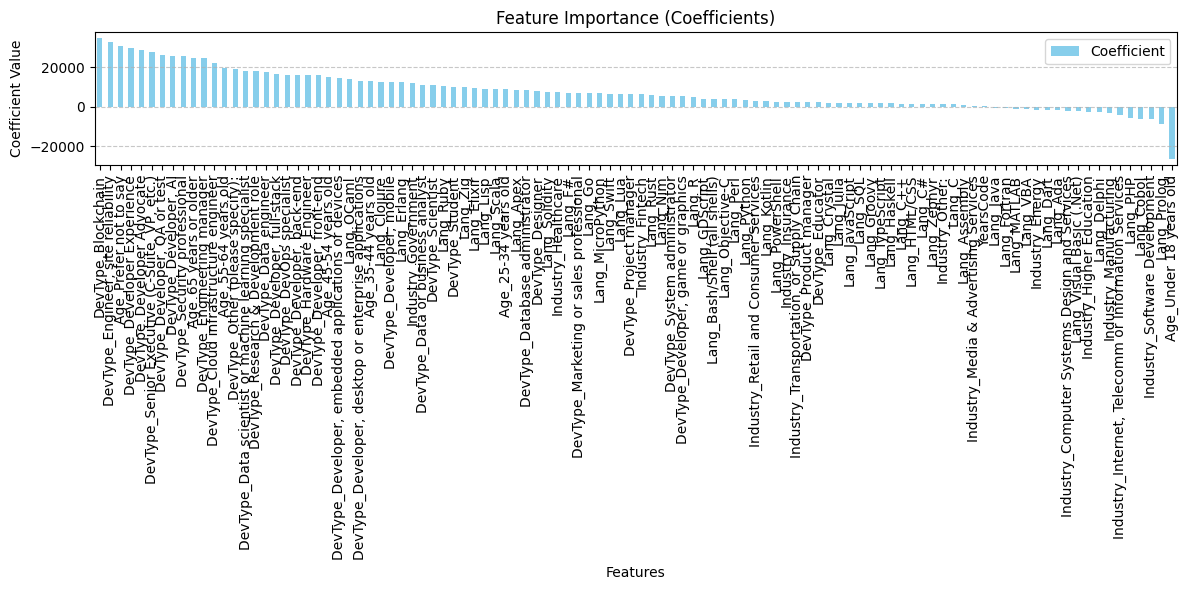

In [31]:
# Visualize feature importance
coefficients.plot(kind='bar', figsize=(12, 6), color='skyblue')
plt.title("Feature Importance (Coefficients)")
plt.xlabel("Features")
plt.ylabel("Coefficient Value")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()